In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import IPython.display as display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.losses import SparseCategoricalCrossentropy

import preprocessing as prep

In [2]:
input_dir = "/Users/richardwang/Documents/Hydroponics/original_dataset/"
data_dir = Path(input_dir)


In [3]:
# Change the format of all the images in the input directory to the specified format. Can be used on single images or a directory of images.

prep.change_format(input_dir, "png", keep= False)

Error: Cannot open .DS_Store. Skipping...
The image hydroponics_lettuce_FN_47.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_53.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_37.jpeg has been changed to the png format.
The image hydroponics_lettuce_FN_52.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_50.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_44.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_17.jpeg has been changed to the png format.
The image hydroponics_lettuce_FN_51.jpg has been changed to the png format.
hydroponics_lettuce_FN_13.webp is not an image file. Skipping...
The image hydroponics_lettuce_FN_41.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_16.jpeg has been changed to the png format.
The image hydroponics_lettuce_FN_40.jpg has been changed to the png format.
The image hydroponics_lettuce_FN_42.jpg has been chang

In [4]:
# Creating a dataset with a pre-defined pipeline
data_original = tf.keras.utils.image_dataset_from_directory(input_dir) # not all image formats supported

Found 226 files belonging to 4 classes.


In [5]:
data_classes = data_original.class_names
data_classes

['deficiency_nitrogen',
 'deficiency_phosphorus',
 'deficiency_potassium',
 'healthy']

In [ ]:
# get a batch of images

healthy = list(data_dir.glob('healthy/*'))
nitro = list(data_dir.glob('deficiency_nitrogen/*'))
phos = list(data_dir.glob('deficiency_phosphorus/*'))
pota = list(data_dir.glob('deficiency_potassium/*'))

for image in phos[-5:]:
    display.display(Image.open(str(image)))


In [6]:
# this cell creates a folder for the test data that is randomly selected from the original dataset. Please only 
# run this cell once, as it will fill the test folder with images.

import os
import shutil
import numpy as np

# directories
src_dir = input_dir
test_dir = "/Users/richardwang/Documents/Hydroponics/test_data"

# make sure destination directory exists. If it already exists, pass this step.
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)

    # proportion of images to use for testing
    test_ratio = 0.2

    # seed for reproducibility
    np.random.seed(42)

    # for each class directory in the source directory
    for class_dir in os.listdir(src_dir):
        if os.path.isdir(os.path.join(src_dir, class_dir)):
            # list all image files in this class directory
            images = os.listdir(os.path.join(src_dir, class_dir))
            
            # randomly shuffle the images
            np.random.shuffle(images)
            
            # determine the number of images to move
            n_test_images = int(len(images) * test_ratio)
            
            # create a new directory for this class in the destination directory
            os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
            
            # move the test images to the destination directory
            for image in images[:n_test_images]:
                shutil.move(os.path.join(src_dir, class_dir, image), os.path.join(test_dir, class_dir, image))
else:
    print("Test data already exists. This step is skipped.")


Test data already exists. This step is skipped.


In [30]:
batch_size = 32
image_size = (256, 256)
s1,s2 = image_size

test_dir = "/Users/richardwang/Documents/Hydroponics/test_data"

datagen= ImageDataGenerator(
    rotation_range=135,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range = 0.05,
    zoom_range = 0.5,
    rescale= 1./255,
    # brightness_range =  (0.0,1),
    fill_mode="constant", # cval is the value used for points outside the boundaries when fill_mode is "constant"
                        # besides "constant" there are "nearest", "reflect" and "wrap". the fill_mode is used when the image is augmented and the size of the image changes
    validation_split = 0.2
    )

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(directory=input_dir, batch_size=batch_size, target_size=image_size, color_mode="rgb", class_mode = 'sparse')
val_generator = val_datagen.flow_from_directory(directory= input_dir, batch_size=batch_size, target_size=image_size, color_mode="rgb", class_mode = 'sparse')


Found 226 images belonging to 4 classes.
Found 226 images belonging to 4 classes.


In [31]:
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=( s1, s2, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

In [32]:
# Compile the model
model.compile(optimizer='adam',
              # loss='sparse_categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 128)      

 flatten_2 (Flatten)         (None, 115200)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               14745728  
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 14839492 (56.61 MB)
Trainable params: 14839492 (56.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
steps_per_epoch = train_generator.n // batch_size
num_epochs = 30
validation_steps = len(val_generator)

# # Train the model
# model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs)

    
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs,
    validation_data=val_generator, 
    validation_steps=validation_steps
)
# # Train the model
# history = model.fit(data, validation_data=val_data, epochs=40)


Epoch 1/30
7/7 [==============================] - 17s 3s/step - loss: 7.6913 - accuracy: 0.2938 - val_loss: 1.4574 - val_accuracy: 0.2345
Epoch 2/30
7/7 [==============================] - 15s 2s/step - loss: 1.4241 - accuracy: 0.2165 - val_loss: 1.3783 - val_accuracy: 0.2168
Epoch 3/30
7/7 [==============================] - 17s 2s/step - loss: 1.3776 - accuracy: 0.2500 - val_loss: 1.3861 - val_accuracy: 0.3053
Epoch 4/30
7/7 [==============================] - 16s 2s/step - loss: 1.3847 - accuracy: 0.2732 - val_loss: 1.3853 - val_accuracy: 0.2788
Epoch 5/30
7/7 [==============================] - 16s 2s/step - loss: 1.3620 - accuracy: 0.3093 - val_loss: 1.4158 - val_accuracy: 0.2832
Epoch 6/30
7/7 [==============================] - 16s 2s/step - loss: 1.3981 - accuracy: 0.2887 - val_loss: 1.3676 - val_accuracy: 0.2743
Epoch 7/30
7/7 [==============================] - 15s 2s/step - loss: 1.3874 - accuracy: 0.3093 - val_loss: 1.4381 - val_accuracy: 0.3230
Epoch 8/30
7/7 [==================

In [ ]:
# Evaluate the model on the validation data 
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

4/4 [==============================] - 2s 375ms/step - loss: 1.3722 - accuracy: 0.3750
Validation Loss: 1.3721657991409302
Validation Accuracy: 0.3750000298023224


In [21]:

# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

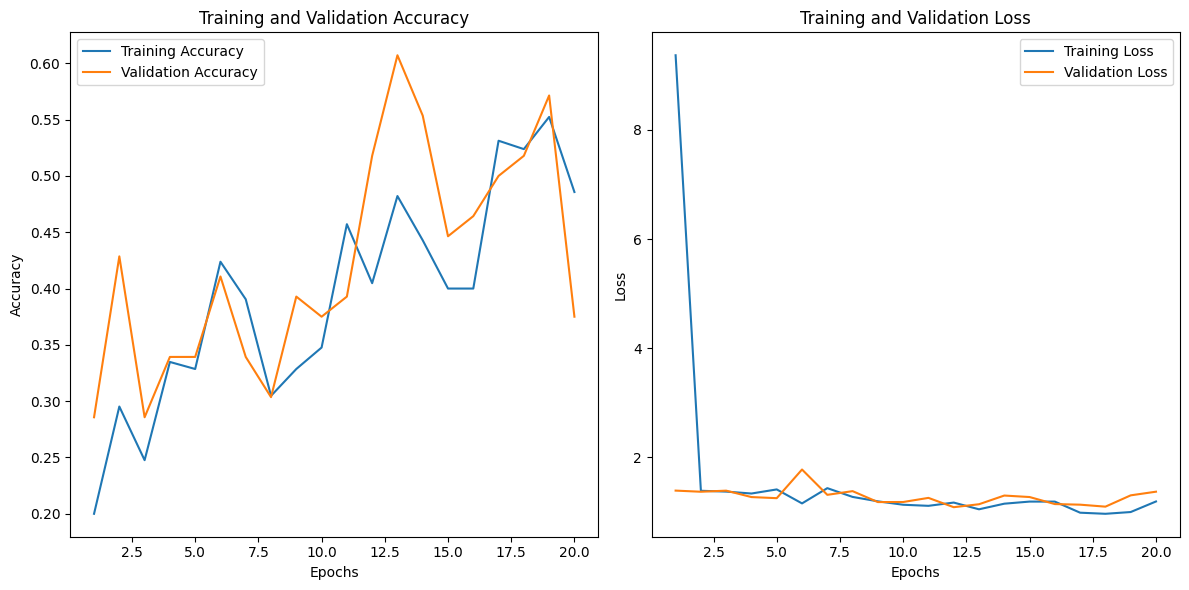

In [22]:

# Create line plots
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# load ResNet50 model without classification layers
base_model = ResNet50(weights='imagenet', include_top=False)


In [24]:

# add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # let's add a fully-connected layer
predictions = Dense(4, activation='softmax')(x)  # we have 4 classes

# define the new model
model = Model(inputs=base_model.input, outputs=predictions)


In [28]:

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam', loss= tf.keras.losses.SparseCategoricalCrossentropy() , metrics=['accuracy'])


In [29]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/20
14/14 [==============================] - 20s 1s/step - loss: 6.4274 - accuracy: 0.2571 - val_loss: 7.5824 - val_accuracy: 0.2857
Epoch 2/20
14/14 [==============================] - 18s 1s/step - loss: 4.8603 - accuracy: 0.2143 - val_loss: 3.3183 - val_accuracy: 0.2143
Epoch 3/20
14/14 [==============================] - 20s 2s/step - loss: 2.7648 - accuracy: 0.2619 - val_loss: 1.8358 - val_accuracy: 0.3036
Epoch 4/20
14/14 [==============================] - 22s 2s/step - loss: 1.9886 - accuracy: 0.3095 - val_loss: 1.8038 - val_accuracy: 0.2500
Epoch 5/20
14/14 [==============================] - 23s 2s/step - loss: 1.5888 - accuracy: 0.3048 - val_loss: 1.5390 - val_accuracy: 0.2500
Epoch 6/20
14/14 [==============================] - 24s 2s/step - loss: 1.6283 - accuracy: 0.2762 - val_loss: 1.6763 - val_accuracy: 0.3214
Epoch 7/20
14/14 [==============================] - 31s 2s/step - loss: 1.7465 - accuracy: 0.3095 - val_loss: 1.7320 - val_accuracy: 0.2500
Epoch 8/20
14/14 [==